<br><br>

<font color=#0C2C76 ><font>
<p style = "font-family:courier;">
    <font size="7">
        Interactive Learning
    </font>    
</p>

 <br>
    
<font color=#CF3A69><font>
<p style = "font-family:optima;">
    <font size="6">
        Homework #4 - Model Free Learning in MDPs
    </font>    
<font color=#000000> <font>
</p>

> $\textit{Sahand Khoshdel - 810196607}$

In [191]:
import numpy as np
import matplotlib.pyplot as plt

MAP_LENGTH = 10
MAP_WIDTH = 10
MAX_EPOCHS = 5000

nS = MAP_LENGTH*MAP_WIDTH
nA = 4

In [7]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

In [96]:
env =  GridworldEnv()
print(env.reset())
env._render()

44
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


In [213]:
total_rewards = []
actions_taken = []
max_epoch = 1000
for e in range(max_epoch):
    rewards = []
    env.reset()
    s = init
    while(True):
        a = 0 
        action = env.action_space.sample()
        #print(f"action chosen: {action}")
        state, reward, done, info = env.step(action) # Take a random action
        a = a + 1 
        #print(f"S':{state}")
        #print(f"Probability taking action:{info}")
        #print(f"Reward:{reward}\n\n\n")
        rewards.append(reward)
        if(done==True):
            total_reward = sum(rewards)
            #print(f"Agent Reached Goal with Total Reward = {total_reward}")
            total_rewards.append(total_reward)
            break
avg_reward = sum(total_rewards)/len(total_rewards)
print(f"Agent Reached Terminal State {max_epoch} times with an Average Regret of: {abs(avg_reward)}")

Agent Reached Terminal State 1000 times with an Average Regret of: 245.324


In [214]:
def e_greedy(q_function_matrix,e = 0.3):
    #print(f"epsilon : {e}")
    policy_matrix = np.ones((nS,nA))/nA
    
    for s in range(nS):
        for a in range(nA):
            
            policy_matrix[s][a] = (e/nA)
            
            opt_action = np.argmax(q_function_matrix[s])
            
            if(a==opt_action):
                policy_matrix[s][a] =  policy_matrix[s][a] + (1-e)
                
            return policy_matrix
        
        
def boltzman(q_function_matrix,T):
    
    policy_matrix = np.zeros((nS,nA))
    
    for s in range(nS):
        for a in range(nA):
            
            policy_matrix[s][a] = (np.exp(q_function_matrix[s][a])/np.sum(np.exp(q_function_matrix[s])))
            return policy_matrix

In [222]:
import itertools

def next_step_generator(current_state,policy_matrix):
    #print(policy_matrix[current_state])
    action = np.random.choice(nA, 1, p = policy_matrix[current_state]) # Choosing action policy based
    next_state, reward, done, info = env.step(action[0]) # Take chosen action, observe reward, next state
   
    return next_state,action,reward,done

# yed for too main bayad bezairi !

def monte_carlo_on_policy(current_state,policy_matrix,q_function_matrix, soft_policy = "e-greedy",e_value = 0.3, gamma = 0.9,emt=False):
    states = []
    rewards = []
    actions = []
    
    returns = [[[] for a in range(nA)] for s in range(nS)] # create empty list for returns for each state-action pair 
    
    for i in itertools.count():# iterating over states till an episode finishes

        if(soft_policy == "e-greedy"):

            policy_matrix = e_greedy(q_function_matrix,e_value) # policy construction
            
            
        step_next_state, step_action, step_reward, done = next_step_generator(current_state, policy_matrix) # episode generation
        if(done==True):
            #print("Agent Reached Terminal State! Total Reward:")
            break
        states.append(step_next_state)
        rewards.append(step_reward)
        actions.append(step_action)
        
        current_state = step_next_state
        #print(current_state)

    G = 0
    states_reversed = states[::-1]
    actions_reversed = actions[::-1]
    rewards_reversed = rewards[::-1]

    for i,state in enumerate(states_reversed):

        action = actions_reversed[i][0]
        reward = rewards_reversed[i]

        G = G + (reward*gamma)
        #print(f"s: {state} ,states:{states}\n\n")
        if( (state not in states[:len(states)-i-1]) and ((action not in actions[:len(actions)-i-1]))):
            returns[state][action].append(G)
            
            q_function_matrix[state][action]  = sum(returns[state][action])/len(returns[state][action])
            if(emt==True):
                print(f"q function for state 4: {q_function_matrix[2]}")
            #print(q_function_matrix)
            policy_matrix = e_greedy(q_function_matrix[state])
            
    sum_rewards = sum(rewards)
    
    return sum_rewards

In [ ]:
total_rewards = []
epsilon = 1

for e in range(MAX_EPOCHS):
    em = False
    init = env.reset()   
    q_function_matrix = np.zeros((nS,nA))
    if (e%2 == 0):
        epsilon = max(epsilon * 0.99, 0.01)
    if(e%100 == 0):
        em = True
    policy = e_greedy(q_function_matrix,epsilon)
    total_reward = monte_carlo_on_policy(init,policy,q_function_matrix,e_value = epsilon,emt=em)  
    total_rewards.append(total_reward)


print(f"Total Reward Average over {MAX_EPOCHS} epochs : {total_rewards[-1]}")

q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]
q function for state 4: [0. 0. 0. 0.]


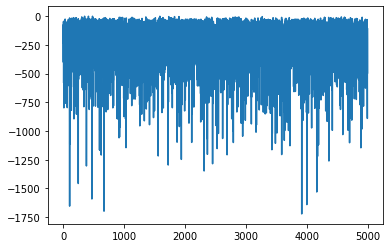

In [195]:
plt.plot(total_rewards)